1. data source: https://www.kaggle.com/uciml/sms-spam-collection-dataset?select=spam.csv

In [79]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
# import keras
# from keras.models import Model
# import keras.backend as K
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report, accuracy_score
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
import transformers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [2]:
print(tf.__version__)
print(transformers.__version__)

2.4.1
4.3.0


In [4]:
params = {'BATCH_SIZE': 64,
          'SEED': 2021,
          'LR': 1e-3,
          'MAX_FEATURES': 5000, # google suggests <= 20000
          'SEQ_LENGTH': 250,
          'EMBEDDING_DIM': 16,
          'DROP_RATE': 0.2}
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

# 1 load data

In [6]:
df = pd.read_csv('/Users/wegzheng/data/1_csv_data/Data_Mining/kaggle/SMS_SPAM/spam.csv', encoding='ISO-8859-1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [7]:
df = df[['v1', 'v2']]
df.shape

(5572, 2)

In [8]:
df = df.dropna()
df.shape

(5572, 2)

In [9]:
df = shuffle(df)
df.head(3)

,v1,v2
5370,spam,dating:i have had two of these. Only started a...
1322,ham,Oh just getting even with u.... u?
776,ham,Why don't you go tell your friend you're not s...


In [10]:
df = df.rename(columns={'v1':'label', 'v2':'text'}).reset_index(drop=True)
df.head(3)

,label,text
0,spam,dating:i have had two of these. Only started a...
1,ham,Oh just getting even with u.... u?
2,ham,Why don't you go tell your friend you're not s...


In [59]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [11]:
# clean text
df_cln = df.copy()
df_cln['text'] = df_cln['text'].map(preprocess_sentence)
df_cln['text'][:2]

0    dating two started sent text talk sport radio ...
1                                         getting even
Name: text, dtype: object

In [12]:
df_cln['response'] = np.where(df_cln['label']=='ham', 0, 1)
df_cln.tail()

,label,text,response
5567,ham,yup izzit still raining heavily cos mrt outside,0
5568,ham,wont anything,0
5569,ham,know lab goggles went,0
5570,ham,nice ready thursday,0
5571,spam,free week entry textpod chance win ipod cash e...,1


In [13]:
df_cln.groupby('label')['text'].count()

label
ham     4825
spam     747
Name: text, dtype: int64

In [14]:
X_arr = np.asarray(df_cln[['text']])
y_arr = np.asarray(df_cln[['response']])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3565, 1)
(892, 1)
(1115, 1)


# 2 modeling
## 2.1 raw keras

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import losses

In [60]:
# define vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=params['MAX_FEATURES'],
    output_mode='int', # int, count, tf-idf
    output_sequence_length=params['SEQ_LENGTH']
)

In [61]:
vectorize_layer.adapt(X_train)

In [62]:
# @tf.keras.utils.register_keras_serializable()
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [63]:
# retrieve a batch (of 32 reviews and labels) from the dataset
first_review, first_label = X_train[0], y_train[0]
print(' ')
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

 
Review ['haf keep busy']
Label [0]
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[284,  93, 410,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   

In [64]:
def convert_df2dataset(x, y):
    training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(x, tf.string),
            tf.cast(y, tf.int32)
        )
    ))
    return training_dataset

In [65]:
raw_train_ds = convert_df2dataset(X_train, y_train)
raw_val_ds = convert_df2dataset(X_val, y_val)
raw_test_ds = convert_df2dataset(X_test, y_test)

In [66]:
# build data for model
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [67]:
# settings for model performance
auto_tune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=auto_tune)
val_ds = val_ds.cache().prefetch(buffer_size=auto_tune)
test_ds = test_ds.cache().prefetch(buffer_size=auto_tune)

# create model structure
model = tf.keras.Sequential([
    layers.Embedding(params['MAX_FEATURES'] + 1, params['EMBEDDING_DIM']),
    layers.Dropout(params['DROP_RATE']),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(params['DROP_RATE']),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80016     
_________________________________________________________________
dropout_38 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 80,033
Trainable params: 80,033
Non-trainable params: 0
_________________________________________________________________


In [68]:
%%time
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.4))

# fit the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2)

# evaluate the model with test data
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/50
3565/3565 - 3s - loss: 0.4022 - binary_accuracy: 0.8656 - val_loss: 0.4018 - val_binary_accuracy: 0.8554
Epoch 2/50
3565/3565 - 2s - loss: 0.3779 - binary_accuracy: 0.8656 - val_loss: 0.3893 - val_binary_accuracy: 0.8554
Epoch 3/50
3565/3565 - 2s - loss: 0.3617 - binary_accuracy: 0.8656 - val_loss: 0.3711 - val_binary_accuracy: 0.8554
Epoch 4/50
3565/3565 - 2s - loss: 0.3380 - binary_accuracy: 0.8656 - val_loss: 0.3350 - val_binary_accuracy: 0.8554
Epoch 5/50
3565/3565 - 2s - loss: 0.2899 - binary_accuracy: 0.8656 - val_loss: 0.2702 - val_binary_accuracy: 0.8554
Epoch 6/50
3565/3565 - 2s - loss: 0.2201 - binary_accuracy: 0.8847 - val_loss: 0.1917 - val_binary_accuracy: 0.8991
Epoch 7/50
3565/3565 - 2s - loss: 0.1528 - binary_accuracy: 0.9318 - val_loss: 0.1353 - val_binary_accuracy: 0.9428
Epoch 8/50
3565/3565 - 2s - loss: 0.1089 - binary_accuracy: 0.9585 - val_loss: 0.1030 - val_binary_accuracy: 0.9552
Epoch 9/50
3565/3565 - 2s - loss: 0.0878 - binary_accuracy: 0.9691 - val

In [69]:
# plot history training results
history_dict = history.history
# history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

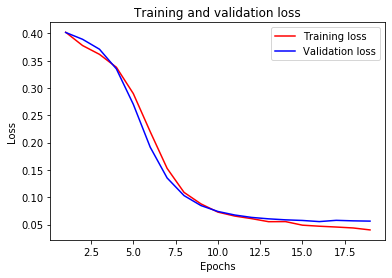

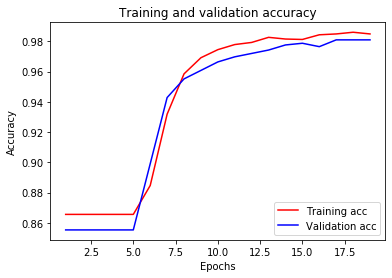

In [70]:


# plot on loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot on accuracy
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### performance on test data

In [76]:
preds = model.predict_classes(test_ds)

In [74]:
preds

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

In [80]:
f1 = f1_score(y_test,preds)
print('F1 score',f1)
print('Classification Report')
print(classification_report(y_test,preds,
#                             target_names=target_names
                           ))

F1 score 0.8965517241379309
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       976
           1       0.96      0.84      0.90       139

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.98      0.98      0.98      1115



In [81]:
accuracy_score(y_test,preds)

0.9757847533632287

## 2.2 BERT method

In [ ]:
# import keras
# from keras.models import Model
# import keras.backend as K
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model

In [19]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('/Users/wegzheng/Downloads/BERT/',num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at /Users/wegzheng/Downloads/BERT/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
df_cln['text']

0       dating two started sent text talk sport radio ...
1                                            getting even
2       tell friend sure want live smokes much spend h...
3       need lar jus testing phone card dunno network ...
4                                          dont kick coco
                              ...                        
5567      yup izzit still raining heavily cos mrt outside
5568                                        wont anything
5569                                know lab goggles went
5570                                  nice ready thursday
5571    free week entry textpod chance win ipod cash e...
Name: text, Length: 5572, dtype: object

In [21]:
pd.DataFrame(X_train).rename(columns={0:'text'})[:3]

,text
0,haf keep busy
1,nice nice working
2,haha sounds crazy dunno tahan anot


In [22]:
def gen_bert_tokenizer(arr, labels):
    sentences = pd.DataFrame(arr).rename(columns={0:'text'})['text']
    input_ids=[]
    attention_masks=[]

    for sent in sentences:
        bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    labels=np.array(labels)
    
    return input_ids, attention_masks, labels

In [23]:
input_ids_tr, attenten_masks_tr, labels_tr = gen_bert_tokenizer(X_train[:2000], y_train[:2000]) # limited training size
input_ids_va, attenten_masks_va, labels_va = gen_bert_tokenizer(X_val, y_val)
input_ids_ts, attenten_masks_ts, labels_ts = gen_bert_tokenizer(X_test, y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [26]:
history=bert_model.fit([input_ids_tr,attenten_masks_tr],labels_tr,
#                        batch_size=params['BATCH_SIZE'], 
                       batch_size=32, 
                       epochs=3, 
                       validation_data=([input_ids_va,attenten_masks_va],labels_va),
                       callbacks=callbacks)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 388s 6s/step - loss: 0.3662 - accuracy: 0.8868 - val_loss: 0.0816 - val_accuracy: 0.9787
Epoch 2/3
63/63 [==============================] - 371s 6s/step - loss: 0.0565 - accuracy: 0.9871 - val_loss: 0.0649 -

In [27]:
preds = bert_model.predict([input_ids_ts,attenten_masks_ts],batch_size=32)
# pred_labels = preds.argmax(axis=1)


AttributeError: 'TFSequenceClassifierOutput' object has no attribute 'argmax'

In [55]:
pred_arr = tf.nn.softmax(preds[0], axis=-1)
pred_labels = tf.argmax(pred_arr, axis=1).numpy()

In [56]:
pred_arr

<tf.Tensor: shape=(1115, 2), dtype=float32, numpy=
array([[0.9976336 , 0.00236639],
       [0.9966054 , 0.00339455],
       [0.9971909 , 0.00280909],
       ...,
       [0.99651873, 0.00348123],
       [0.9968278 , 0.00317217],
       [0.00424785, 0.9957521 ]], dtype=float32)>

In [57]:
pred_labels

array([0, 0, 0, ..., 0, 0, 1])

In [58]:
f1 = f1_score(labels_ts,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(labels_ts,pred_labels,
#                             target_names=target_names
                           ))

print('Training and saving built model.....')

F1 score 0.9014084507042254
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       976
           1       0.88      0.92      0.90       139

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.94      1115
weighted avg       0.98      0.97      0.98      1115

Training and saving built model.....


In [82]:
accuracy_score(labels_ts,pred_labels,)

0.9748878923766816